## imports

In [57]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import json
data_pth = Path('../data/')

## Constants

In [58]:
NIU = 99999999
with open(data_pth / 'cpi99_cons.json') as fin:
    cpi99_cons = json.load(fin)

Drop useless columns

In [105]:
raw_data = pd.read_csv('../data/beginner.csv')
simple_data = raw_data[[
    'YEAR', 'SERIAL', 'REGION', 'NFAMS', 'PERNUM', 
    'RACE', 'AGE', 'SEX', 'EMPSTAT', 'OCC', 'UHRSWORKT', 
    'WKSTAT', 'JOBCERT', 'EDUC', 'INCWAGE', 'OINCWAGE']]
simple_data.to_csv('../data/simple_data.csv', index=False)

In [102]:
raw_data.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'HWTFINL', 'CPSID', 'ASECFLAG', 'HFLAG',
       'ASECWTH', 'REGION', 'STATEFIP', 'NFAMS', 'PERNUM', 'WTFINL', 'CPSIDP',
       'ASECWT', 'AGE', 'SEX', 'RACE', 'MARST', 'BPL', 'EMPSTAT', 'OCC',
       'UHRSWORKT', 'WKSTAT', 'JOBCERT', 'EDUC', 'EDDIPGED', 'INCWAGE',
       'OINCWAGE'],
      dtype='object')

In [60]:
incwage = simple_data['INCWAGE']
print('total reports:', len(incwage))
print('number of 0 wage:', np.count_nonzero(incwage == 0))
print('number of N.I.U wage:', np.count_nonzero(incwage == 99999999))
print('number of ? wage:', np.count_nonzero(incwage == 99999998))
print('number of NaN wage:', np.count_nonzero(incwage.isna()))
print('number of readable wage:', np.count_nonzero((incwage > 0) & (incwage < 99999998)))


total reports: 54737
number of 0 wage: 7496
number of N.I.U wage: 5543
number of ? wage: 0
number of NaN wage: 30160
number of readable wage: 11538


In [106]:
filtered = simple_data[(simple_data['INCWAGE'] >= 0) & (simple_data['INCWAGE'] < NIU)].reset_index(drop=True)

filtered_nonzero = filtered[filtered['INCWAGE'] > 0].reset_index(drop=True)


In [78]:
import seaborn as sns

def corr_heatmap(df):
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)


In [63]:
# per individual

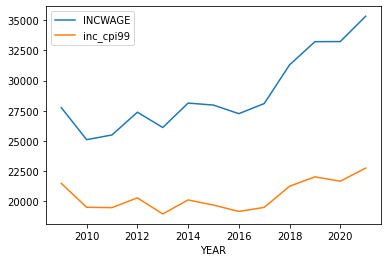

In [107]:
def clean_wage(df):
    # df['OINCWAGE'] = df['OINCWAGE'].replace(np.nan, 0).replace(99999999, 0).replace(99999998, 0)
    # df['inc_salary'] = df['INCWAGE'] - df['OINCWAGE']

    df['cpi99'] = df['YEAR'].apply(lambda yr : cpi99_cons[str(yr)])
    df['inc_cpi99'] = df['INCWAGE'] * df['cpi99']

    df.groupby('YEAR').mean()['INCWAGE'].plot(legend=True)
    df.groupby('YEAR').mean()['inc_cpi99'].plot(legend=True)

# clean_wage(filtered_nonzero)
clean_wage(filtered)
plt.savefig('incwage_cpi99.png')


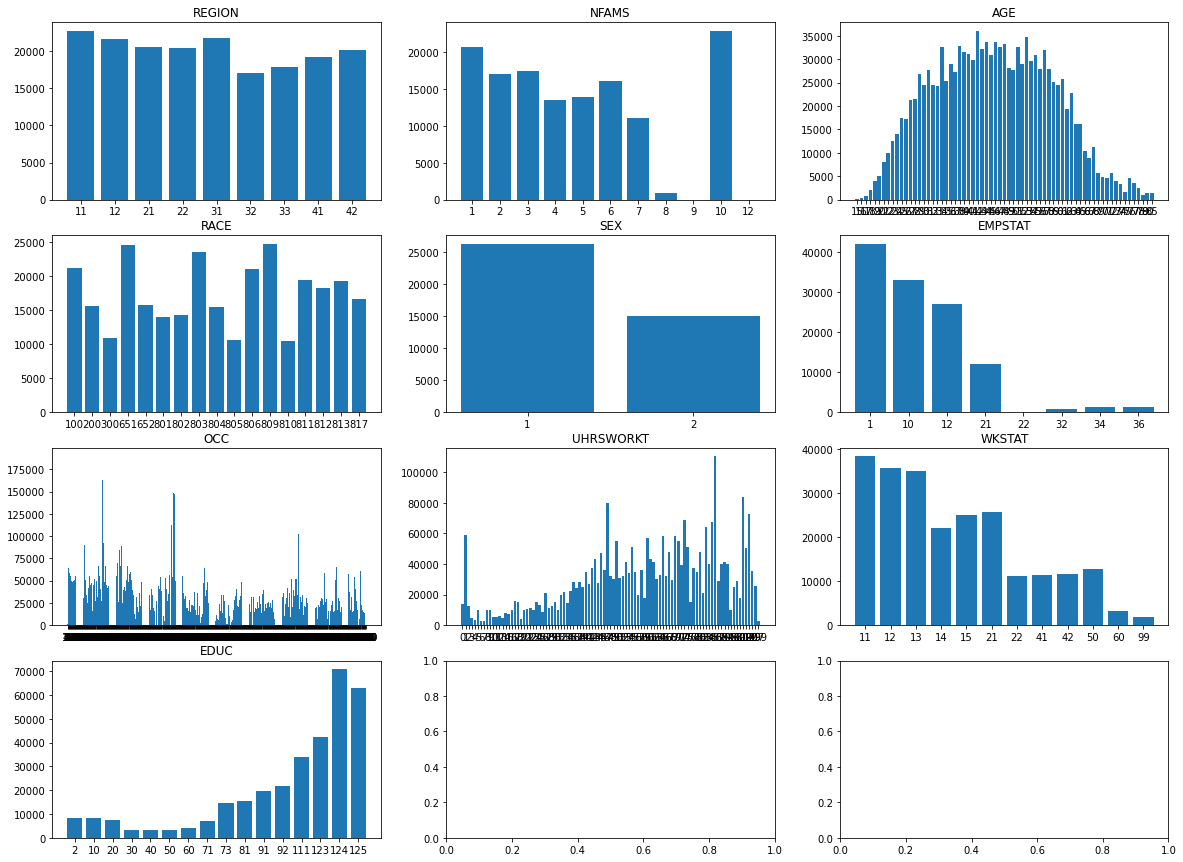

In [121]:
def display_categ(df):
    indices = ['REGION', 'RACE', AGE', 'SEX', 'EMPSTAT', 'OCC', 'UHRSWORKT', 'WKSTAT', 'EDUC']
    
    fig, axs = plt.subplots(4, 3, figsize=(20, 15), constrained_layout=False)

    for i in range(len(indices)):
        ax = axs.flat[i]

        it = indices[i]
        ser = df.groupby(it).mean()['inc_cpi99']

        ax.bar(list(map(str, ser.index)), ser.values.tolist())
        ax.set_title(it)
    
    return fig, axs

    # df.groupby(it).mean()['inc_cpi99'].plot(kind="bar", legend=True)
    # plt.figure()

    # for idx in indices:
    #     display_categ(filtered, idx)
fig, axs = display_categ(filtered)

In [122]:
fig.savefig('factors_vs_inc.png')

30


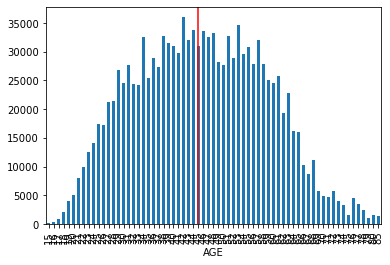

In [77]:
def age_score(df):
    salary_vs_age = df[['AGE', 'inc_cpi99']]

    mean_inc_by_age = df.groupby('AGE').mean()['inc_cpi99']
    mean_inc_by_age.plot(kind='bar')
    
    age_lst = mean_inc_by_age.index.tolist()

    l = np.min(age_lst)
    r = np.max(age_lst)
    while l <= r:
        mid = (l + r) >> 1
        lower = mean_inc_by_age.iloc[:mid].sum()
        upper = mean_inc_by_age.iloc[mid:].sum()
        if lower >= upper:
            r = mid - 1
        else:
            l = mid + 1
    
    plt.axvline(r, color='red')
    print(r)


age_score(filtered)
    

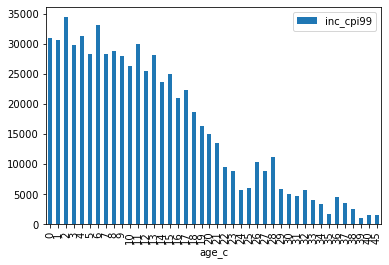

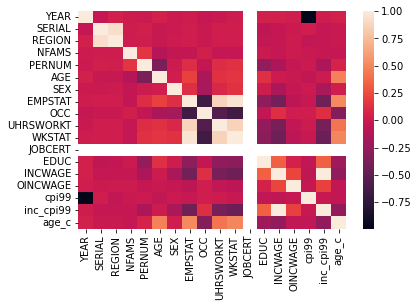

In [91]:
filtered['age_c'] = abs(filtered['AGE'] - 40)
display_categ(filtered, 'age_c')
corr_heatmap(filtered)

In [98]:
from funcs import *
%load_ext autoreload
%autoreload 2

In [99]:
mse_with_vars(filtered, ['age_c', 'EDUC'], [lambda x : x, lambda x : x])

AttributeError: 'list' object has no attribute 'T'